# Testing different dynamical systems-inspired training strategies for RNNs and NeuralODEs

We will start out by using the Lorenz63 system:

\begin{aligned}
&\dot{x} = \sigma(y-x)\\
&\dot{y} = x(\rho-z)-y\\
&\dot{z} = xy-\beta z
\end{aligned}

with the parameters $\sigma = 10, \beta = 8/3, \rho = 28$ chosen so that the system displays chaotic behavior.

Following Hess et al. Generalized Teacher Forcing for Learning Chaotic Dynamics, ICML (2023)., the train and test sets are each comprised of a single trajectory 
with initial condition chosen as $\boldsymbol{u_0} = (x_0, y_0, z_0)^T \sim \mathscr{N}(\boldsymbol{0}, \boldsymbol{I})$ with $t=\{i\Delta t\}_{i=0}^{N-1}$ with $\Delta t = 0.01$ and $N=10^5$.

The training set is contaminated with Gaussian observation noise corresponding to 5% of the data standard deviation.

In [ ]:
from functools import partial

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import Lorenz63, solve_ode
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.models import NeuralODE
from jaxtyping import Array, Float
from matplotlib_utils.axes_setters import set_labels


In [2]:
lorenz = Lorenz63()
lorenz

Lorenz63(sigma=10, beta=2.6666666666666665, rho=28)

key = jax.random.PRNGKey(0)
u0_train_test = jax.random.normal(key, shape=(2, 3))

dt = 0.01
t = jnp.arange(1e5) * dt

dataset = TimeSeriesDataset.from_dynamical_system(lorenz, t, u0_train_test)
dataset.save("./data/lorenz.hdf5")

In [4]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")

In [5]:
u_train_test = dataset_loaded.u
u_train_mean = jnp.mean(u_train_test[0], axis=0)
u_train_std = jnp.std(u_train_test[0], axis=0)
u_train_test_norm = (u_train_test - u_train_mean) / u_train_std

u_train, u_test = u_train_test_norm

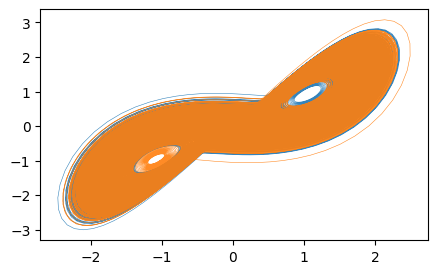

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_kwargs = {"linewidth": 0.4, "alpha": 0.9}
ax.plot(u_train[:, 0], u_train[:, 1], **plot_kwargs)
ax.plot(u_test[:, 0], u_test[:, 1], **plot_kwargs)

In [7]:
def split_into_chunks(
    sequence: Float[Array, " N"], chunk_size: int
) -> tuple[Float[Array, "B N"], Float[Array, " N_remainder"] | None]:
    # TODO: Handle batch dimension in the sequence argument
    # TODO: Implement the case when there are overlaps between chunks, as specified by the overlap: int parameter
    chunks = jnp.split(sequence, jnp.arange(chunk_size, len(sequence), chunk_size))
    if len(chunks[-2]) == len(chunks[-1]):
        batched_chunks = jnp.stack(chunks, axis=0)
        remainder = None
    else:
        batched_chunks = jnp.stack(chunks[:-1], axis=0)
        remainder = chunks[-1]
    return batched_chunks, remainder


chunk_length = 77
t_train_batched, remainder = split_into_chunks(dataset_loaded.t, chunk_length)
u_train_batched, remainder = split_into_chunks(u_train, chunk_length)
# assert remainder is None, (
#     "Chunk size does not cleanly divide the sequence into equal-length chunks!"
# )
u_train_batched.shape

(1298, 77, 3)

In [9]:
neuralode = NeuralODE(3, 32, 3)


@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(None, 0, 0))
def solve_neuralode(model, t, u0):
    u_pred = solve_ode(
        model,
        t,
        u0,
        max_steps=2048,
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=4096),
    )
    return u_pred

In [10]:
model = eqx.tree_deserialise_leaves("./results/lorenz_length=10_key=0.eqx", neuralode)

RuntimeError: Deserialised leaf at path (GetAttrKey(name='net'), GetAttrKey(name='layers'), SequenceKey(idx=0), GetAttrKey(name='weight')) has changed dtype from float64 in `like` to float32 on disk.

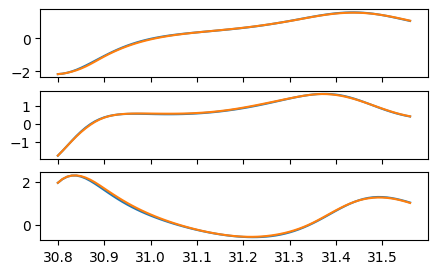

In [13]:
u_pred = solve_neuralode(model, t_train_batched, u_train_batched[:, 0])

chunk_idx = 40
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i])
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i])

In [14]:
u_pred_test = solve_ode(model.rhs, t, u_test[0], max_steps=None)

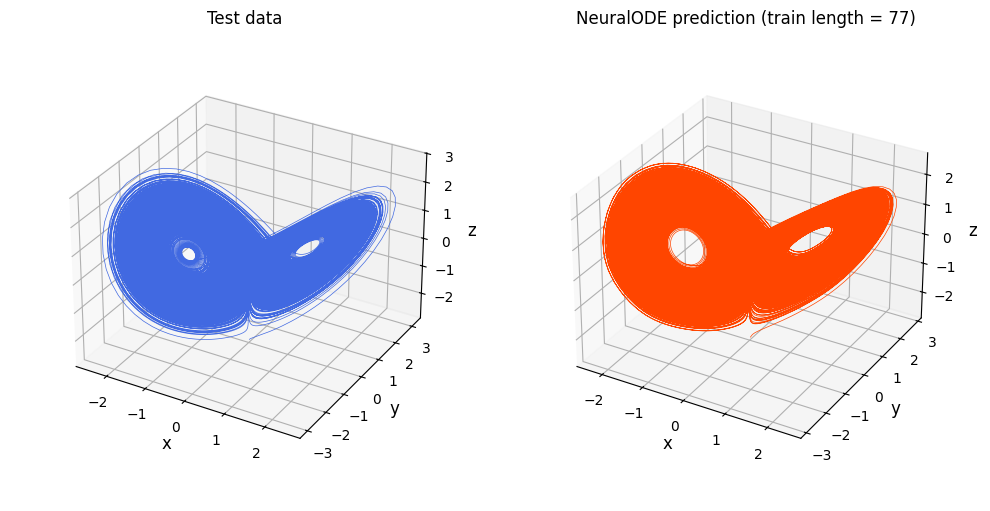

In [18]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].plot(*u_test.T, color="royalblue", **plot_kwargs)
axes[0].set_title("Test data")
axes[1].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[1].set_title(f"NeuralODE prediction (train length = {chunk_length})")
for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)

In [39]:
@eqx.filter_jit
def solve_teacher_forced_naive(
    model,
    t_data,
    u_data,
    u0,
    alpha,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    rtol: float = 1e-4,
    atol: float = 1e-4,
    **diffeqsolve_kwargs,
):
    u_pred_list = [u0]
    u_pred_unforced = [u0]
    u0 = u0
    for t_start, t_end, u_data_i in zip(t_data[:-1], t_data[1:], u_data[1:]):
        u_pred_next = dfx.diffeqsolve(
            dfx.ODETerm(model.rhs),
            solver,
            t_start,
            t_end,
            None,
            u0,
            None,
            saveat=dfx.SaveAt(t1=True),
            stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
            **diffeqsolve_kwargs,
        ).ys[0]
        u_pred_unforced.append(u_pred_next)
        u_pred_next_forced = (1 - alpha) * u_pred_next + alpha * u_data_i
        u_pred_list.append(u_pred_next_forced)
        u0 = u_pred_next_forced
    return jnp.stack(u_pred_list, axis=0), jnp.stack(u_pred_unforced, axis=0)

In [41]:
%%timeit
u_pred_forced, u_pred_unforced = solve_teacher_forced_naive(
    neuralode,
    t_train_batched[chunk_idx],
    u_train_batched[chunk_idx, :, :],
    u_train_batched[chunk_idx, 0, :],
    0.5,
)
u_pred_forced.block_until_ready()

1.24 s ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
u_forced_segments = jnp.stack([u_pred_forced[:-1], u_pred_unforced[1:]], axis=-1)
u_forced_segments.shape

(76, 3, 2)

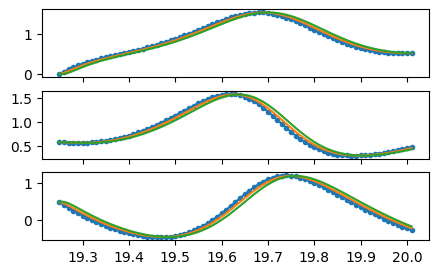

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i], ".-")
    ax.plot(t_train_batched[chunk_idx], u_pred_forced[:, i])
    ax.plot(t_train_batched[chunk_idx], u_pred_unforced[:, i])

(77, 3)

In [ ]:
@eqx.filter_jit
def solve_teacher_forced(
    model,
    t_data,
    u_data,
    u0,
    alpha,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    rtol: float = 1e-4,
    atol: float = 1e-4,
    **diffeqsolve_kwargs,
):
    init = (t_data[0], u_data[0])

    @eqx.filter_vmap
    @eqx.filter_jacrev
    def jacobian(u):
        # Assume autonomous
        return model.rhs(0.0, u, None)

    def inner(carry, t_u):
        t0, u0 = carry
        t1, u1 = t_u
        u1_pred = dfx.diffeqsolve(
            dfx.ODETerm(model.rhs),
            solver,
            t0,
            t1,
            None,
            u0,
            None,
            saveat=dfx.SaveAt(t1=True),
            stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
            **diffeqsolve_kwargs,
        ).ys[0]
        u1_forced = (1 - alpha) * u1_pred + alpha * u1
        carry_new = (t1, u1_forced)
        return carry_new, (u1_forced, u1_pred)

    _, (u_pred_forced, u_pred_unforced) = jax.lax.scan(
        inner, init, (t_data[1:], u_data[1:])
    )
    jac_mean = jnp.mean(jacobian(u_data[1:]), axis=0)

    return u_pred_forced, u_pred_unforced, jac_mean

In [48]:
u_pred_forced, u_pred_unforced, jac_mean = solve_teacher_forced(
    neuralode,
    t_train_batched[chunk_idx],
    u_train_batched[chunk_idx, :, :],
    u_train_batched[chunk_idx, 0, :],
    0.5,
)
u_pred_forced.block_until_ready()

Array([[ 0.01826902,  0.57976371,  0.45416617],
       [ 0.06354773,  0.57560747,  0.3935901 ],
       [ 0.11190878,  0.57181216,  0.32601225],
       [ 0.15923972,  0.56912091,  0.25704958],
       [ 0.20383116,  0.56806068,  0.1893521 ],
       [ 0.24515003,  0.56900869,  0.12412339],
       [ 0.28323935,  0.57223706,  0.06187044],
       [ 0.31841807,  0.57793528,  0.00277855],
       [ 0.35113052,  0.58622215, -0.05310151],
       [ 0.38184697,  0.59717425, -0.10576252],
       [ 0.41100998,  0.61084938, -0.15519486],
       [ 0.43903668,  0.62728684, -0.20137094],
       [ 0.46632105,  0.64650873, -0.24423917],
       [ 0.49323508,  0.66852049, -0.28372097],
       [ 0.5201269 ,  0.6933121 , -0.31970909],
       [ 0.54730099,  0.72087246, -0.35206124],
       [ 0.57502153,  0.75119091, -0.38059772],
       [ 0.60352428,  0.78424283, -0.40510653],
       [ 0.63302252,  0.81998196, -0.42534611],
       [ 0.66370992,  0.85833652, -0.44104683],
       [ 0.69576038,  0.89920632, -0.451

In [52]:
1 - 1 / jnp.linalg.norm(jac_mean, ord=2)

Array(-37.59595651, dtype=float64)

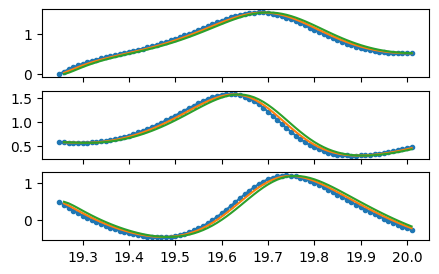

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i], ".-")
    ax.plot(t_train_batched[chunk_idx, 1:], u_pred_forced[:, i])
    ax.plot(t_train_batched[chunk_idx, 1:], u_pred_unforced[:, i])

In [54]:
solve_teacher_forced_batch = eqx.filter_vmap(
    solve_teacher_forced, in_axes=(None, 0, 0, 0, None)
)
u_pred_forced, u_pred_unforced, jac_mean = solve_teacher_forced_batch(
    neuralode,
    t_train_batched,
    u_train_batched,
    u_train_batched[:, 0, :],
    0.5,
)

In [ ]:
jac_mean.shape

(1298, 3, 3)

In [57]:
jac_norm = jnp.linalg.norm(jac_mean, axis=(-2, -1))

In [60]:
1 - 1 / jnp.max(jac_norm)

Array(-15.68489067, dtype=float64)